# Calculate frictional slopes

Copyright 2020 Marco A. Lopez-Sanchez.  
Content under [Creative Commons Attribution license CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/), code under [Mozilla Public License 2.0](https://www.mozilla.org/en-US/MPL/2.0/).

> **Goal of the notebook**: Understand the basics of shear fractures in the brittle field and calculate frictional slopes. The Coulomb failure criterion, Byerlees's and Amonton's laws, the Hubbert-Rubey fluid-pressure hypothesis, and the Anderson's model will be introduced.

In [1]:
# import the required Python scientific libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# set a custom figure style (optional, you can comment on this whole block)
import matplotlib as mpl
mpl.style.use('fivethirtyeight')
mpl.rcParams['figure.facecolor'] = 'ffffff'
mpl.rcParams['axes.facecolor'] = 'ffffff'
mpl.rcParams['axes.edgecolor'] = 'ffffff'

## Step 1: Sliding on a dry fracture: the Amontons, Coulomb laws

### Amontons' law

The first attemp to determine which tangential shearing force is needed to displace two bodies in contact over an approximately planar surface was that of [Amontons](https://en.wikipedia.org/wiki/Guillaume_Amontons) in the 17th century. Amontons established two principles: the tangential shearing force is independent on the contact area (first Amontons law of friction) and proportional to the normal load pressing the surfaces together (second Amontons law of friction). The second law of friction is expressed as follows

$\tau = \mu \sigma_n$

where $\tau$ is the _fracture shear strength_ or _critical shear stress_, $\sigma_n$ is the _fracture-normal stress_, and $\mu$ the so-called _internal coefficient of friction_ that relates both. The _coefficient of friction_ is, however, more properly referred to as the _coefficient of static friction_, since it refers to the condition required to initiate sliding (e.g. Jaeger et al. 2007). Indeed, the shear stress neccesary for maintaning the frictional sliding at a constant velocity is always less than that required to initiate sliding and thus the _coefficient of dynamic friction_ is smaller ($\mu_d < \mu$).

### Coulomb's law

General brittle failure is often described with the _Coulomb criterion_ (Coulomb 1785) that proposed the following relation

$\tau = C_0 + \mu \sigma_n$

where $C_0$ is the _cohesion of the fracture surface_ (or _frictional cohesive strenght_) that accounts for the resistance of the fracture plane to shear when the fracture-normal stress is zero. Coulomb also found that the _fracture shear strength_ is independent of the velocity of sliding, which is known as the third law of friction. Coulomb and, later, Mohr(1900) found that the _coefficient of friction_ ($\mu$) can be related to the angle between the fracture plane and the maximum principal stress as follows

$\mu = tan\phi$

being $\phi$ the _internal angle of friction_.

Most rocks deformed in confined compression develop shear fractures with planes less than 45 degrees from maximum compressive stress. The maximum resolved shear stress on a plane is obtained however when the plane is oriented 45 degrees to the maximum principal stress, so let's see what's happening here. The normal and shear stresses acting along a fracture plane can be estimated using the following relations (e.g. Twiss and Moores, 2007):

$\sigma_n = \frac{\sigma_1+\sigma_3}{2}+\frac{\sigma_1+-\sigma_3}{2}cos2\theta$  

$\sigma_s = \frac{\sigma_1+\sigma_3}{2}sin2\theta$

Now let's plot this for the full range of angles.

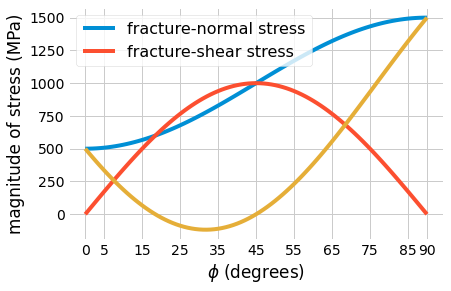

In [2]:
# estimate the whole range of angles between 0 and 90
angles = np.arange(start=0, stop=91)

# set the experimental conditons
sigma1, sigma2, sigma3 = 1500, 500, 500  # Magnitude of principal stresses in MPa

# estimate normal and shear stresses (angles are converted to radians)
sigma_n = (sigma1 + sigma3) / 2 + ((sigma1 - sigma3) / 2) * np.cos(2 * np.deg2rad(angles))
sigma_s = ((sigma1 + sigma3) / 2) * np.sin(2 * np.deg2rad(angles)) 

# make the plot
fig, ax = plt.subplots()

ax.plot(90 - angles, sigma_n, label='fracture-normal stress')
ax.plot(90 - angles, sigma_s, label='fracture-shear stress')
ax.plot(90 - angles, sigma_n - sigma_s)

ax.set(xlabel='$\phi$ (degrees)', ylabel='magnitude of stress (MPa)')
ax.set_xticks([0, 5, 15, 25, 35, 45, 55, 65, 75, 85, 90])
ax.legend(loc='best', fontsize=16)

Explanation: TODO

## Step 2: Byerlee empirical relation

Based on a large number of measures, Byerlee (1978) determine the _coefficient of friction_ ($\mu$) and the _cohesive strength_ $C_0$ for a broad range of rock types. He found that $\mu$ are independent temperature, the rate of deformation and, largely, the rock type; being some notable exceptions clay-rich rocks such as slates or serpentine. Byerlee provided two empirical expressions often referred as _Byerlee's Law_

for 5 < $\sigma$ < 200 MPa  
$\tau = 0.85 \sigma$  

for 200 < $\sigma$ < 1700 MPa  
$\tau = 50 + 0.6 \sigma$

## Step 3: Sliding on a wet facture: the Hubbert-Rubey fluid-pressure hypothesis

TODO

...that the _fault shear strength_ not only depends on the _fault‐normal stress_ and the _internal coefficient of friction_ but also on pore pressure (Terzagui 1936; [Hubbert and Rubey 1959](https://doi.org/10.1130/0016-7606(1959)70[115:ROFPIM]2.0.CO;2)). Intuitively, this means that a fluid under pressure along the fracture plane exerts a force that counteracts the _fault‐normal stress_. This is, the higher the fluid pore pressure, the smaller the _fault shear strength_ ($\tau$).

$\tau = \mu \sigma_{n}^{eff}$

$\tau = \mu (\sigma_n - P) = \mu \sigma_n (1-\lambda)$

where $\sigma_{n}^{eff}$ is the _effective normal stress_ acting on the fracture plane that depends on the $P$ is the pore fluid pressure.

...where $\lambda$ is the ratio between the pore fluid pressure and the lithostatic stress.

> **Keys and clues**
>- Amontons and Coulomb laws indicate that the _fracture shear strengh_ increases linearly with fracture-normal stress. As fracture-normal stress increases with confining pressure, brittle failure becomes difficult with depth.
>- According to Amontons, Coulomb and Byerlee, the _coefficient of friction_ is largely independent of temperature, rate of deformation, and rock type. The latter explains why a brittle fault can cut across diferent lithologies with no change in angle.
>- Although  somewhat counterintuitive, the cohesive strengh of the rocks in the crust is negligible as they are preexisting fracture planes everywhere. There is strong evidence on this from studies measuring the stress state along superdeep boreholes (e.g. [Emmermann and Lauterjung, 1997](https://doi.org/10.1029/96JB03945)). The parameter $C_0$ in Coulomb's is therefore used to account for the _frictional cohesive strenght_ or just taken as zero.
>- Note that using the relation $\mu = tan\phi$ and for $\mu$ values of 0.6-0.85 (as set by Byerlee) most faults (shear fractures) must occur at 30-40 degrees to the maximum principal stress ($\sigma_1$), as is often observed in nature (with notable exceptions such as low-angle faults).
>- All models presented here are valid for _shear fractures_ not for _extensional fractures_.
>
>_**Aside note**: keep in mind that the Coulomb and Amontons' laws are not flow laws (do not relate stress and strain) but a model that describe the critical state at which brittle failure occurs within the brittle field_

## Step 4: The Anderson model

_TODO_

Anderson (1951) made the following assumptions:
- simplified the types of faults in three different cases (normal, inverse, and strike-slip)
- brittle fractures occur according to the Coulomb criterion
- assumed that two of the three principal stresses lies parallel to the earth's surface and the remaining one perpendicular to it

_TODO -> include a figure_

With these assumptions, Anderson recalculated the Coulomb fracture criterion in terms of differential stress $(\sigma_1 - \sigma_3 = \sigma_d)$ and lithostatic stress $(\sigma_L = \rho gh)$, being the lithostatic stress for the three different cases  
- $\sigma_L = \sigma_1$ (normal),
- $\sigma_L = \sigma_3$ (inverse),
- $\sigma_L = \sigma_2 = 0.5(\sigma_1 + \sigma_3)$ (strike-slip).

to finally obtain (_disclaimer: Anderson did not consider the the fuid pore pressure but here it is included_)

$\sigma_d = 2(\sigma_0+\mu \sigma_L (1 - \lambda)) / \sqrt{\mu^2 + 1}-\mu$ - inverse fault

$\sigma_d = 2(\sigma_0+\mu \sigma_L (1 - \lambda)) / \sqrt{\mu^2 + 1}$ - Strike-slip fault

$\sigma_d = -2(\sigma_0-\mu \sigma_L (1 - \lambda)) / \sqrt{\mu^2 + 1}+\mu$ - Normal (extensional) fault

TODO

In [3]:
def Anderson_fault(fault_type, depths, pressure, mu=0.73, lamb=0.36, C0=0.0):
    """ Returns the corresponding differential stress in MPa for a specific depth
    based on the Anderson theory of faulting (Anderson, 1905) and the Coulomb–
    Navier’s law of friction.

    Parameters
    ----------
    fault_type : string
        the type of fault, either 'inverse', 'normal' or 'strike-slip'
    depths : array-like
        an array-like with the depths [km]
    pressure : array-like
        the lithostatic stress of pressure at different depths [GPa]
    mu : scalar between 0 and 1, optional
        Coefficient of friction. Default value 0.73; this is the Rutter
        and Glover (2012) coefficient recalculated from Byerlee (1978) data
    lamb : scalar between 0 and 1, optional
        Hubbert-Rubbey coefficient of fluid pressure. Zero is for dry conditions.
        Default = 0.36
    C0 : positive scalar, optional
        Internal cohesion of the rock [MPa]. Mostly negligible in nature, default
        is zero. Alternatively, this parameter can be used as the frictional
        cohesive strenght as well.
    """

    depths = depths * 1000  # convert km to m
    pressure = pressure * 1e9  # convert GPa to Pa

    if fault_type == 'inverse':
        diff_stress = (2 * (C0 + mu * pressure * (1 - lamb))) / (np.sqrt(mu**2 + 1) - mu)

    elif fault_type == 'strike-slip':
        diff_stress = (2 * (C0 + mu * pressure * (1 - lamb))) / (np.sqrt(mu**2 + 1))

    elif fault_type == 'normal':
        diff_stress = (- 2 * (C0 - mu * pressure * (1 - lamb))) / (np.sqrt(mu**2 + 1) + mu)
    
    else:
        raise ValueError("fault type must be 'inverse', 'strike-slip' or 'normal'")

    return diff_stress / 10**6

## Step 4: First example of a friccional slope

To start simple, let's estimate at which differential stress brittle failure occurs as a function of lithostatic pressure and the type of fault. For this, let's assume that the internal cohesion of the rock is null (_Amontons' law_), that the coefficient of friction is that of the _Byerlee's law_ for low pressures $\mu = 0.85$, and that the rocks are completely dry (i.e. coefficient of fluid pressure equals 0). We also assume that the rock density and gravitational acceleration do not vary in the first 15 km of the crust.

In [4]:
# set the required parameters 
ro_crust = 2750  # average rock density in the crust [kg/m**3]
g = 9.80665      # average gravitational acceleration [m/s**2]

# generate a linear spaced array of depths every 10 m from 0 to 15 km depth
depths = np.linspace(start=0, stop=15, num=1500)

# create a spreadsheet (DataFrame) containing the depths and corresponding lithostatic stresses
data = pd.DataFrame({
    'depths': depths,
    'pressure': (ro_crust * g * depths) / 1e6})  # / 1e6 to obtain GPa
data

,depths,pressure
0,0.000000,0.000000
1,0.010007,0.000270
2,0.020013,0.000540
3,0.030020,0.000810
4,0.040027,0.001079
...,...,...
1495,14.959973,0.403445
1496,14.969980,0.403715
1497,14.979987,0.403985
1498,14.989993,0.404254


In [5]:
data['thrust'] = Anderson_fault('inverse',
                                data['depths'],
                                data['pressure'],
                                mu=0.85,
                                lamb=0.0)

data['normal'] = Anderson_fault('normal',
                                data['depths'],
                                data['pressure'],
                                mu=0.85,
                                lamb=0.0)

data['strike'] = Anderson_fault('strike-slip',
                                data['depths'],
                                data['pressure'],
                                mu=0.85,
                                lamb=0.0)
data

,depths,pressure,thrust,normal,strike
0,0.000000,0.000000,0.000000,-0.000000,0.000000
1,0.010007,0.000270,0.992056,0.212152,0.349552
2,0.020013,0.000540,1.984111,0.424305,0.699105
3,0.030020,0.000810,2.976167,0.636457,1.048657
4,0.040027,0.001079,3.968223,0.848609,1.398210
...,...,...,...,...,...
1495,14.959973,0.403445,1483.123346,317.167697,522.580854
1496,14.969980,0.403715,1484.115402,317.379849,522.930407
1497,14.979987,0.403985,1485.107457,317.592001,523.279959
1498,14.989993,0.404254,1486.099513,317.804153,523.629511


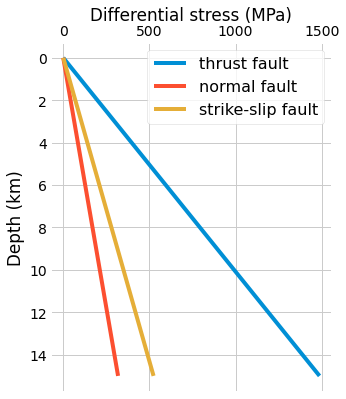

In [6]:
# make the plot
fig2, ax = plt.subplots(figsize=(4.5, 6))

# tweak the figure so that the depth is shown on the y-axis downwards
plt.gca().invert_yaxis()
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')

ax.plot(data['thrust'], data['depths'], label='thrust fault')
ax.plot(data['normal'], data['depths'], label='normal fault')
ax.plot(data['strike'], data['depths'], label='strike-slip fault')

ax.set(xlabel='Differential stress (MPa)', ylabel='Depth (km)')
ax.legend(loc='best', fontsize=16)